In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.8.0


# Maximum likelihood fit

Let's generate a Gaussian mixture dataset and then fit its parameters with maximum likelihood.

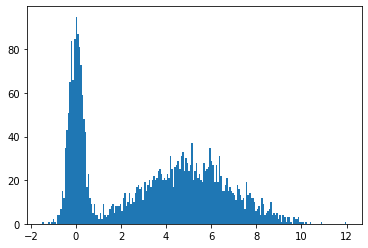

In [3]:
X1 = np.random.normal(size=1000, scale=0.3).astype('float32')
X2 = np.random.normal(size=2000, loc=5., scale=2.).astype('float32')

X = np.concatenate([X1, X2])
np.random.shuffle(X)

plt.hist(X, bins=200);

**Task**:
 - fill the gaps below to perform the max. likelihood fit with the pdf:
$$\text{PDF}(x|\mu_1, \sigma^2_1, \mu_2, \sigma^2_2, \alpha)
= \alpha\cdot\mathscr{N}(x|\mu_1, \sigma_1^2) + (1 - \alpha)\cdot\mathscr{N}(x|\mu_2, \sigma_2^2)$$
 - what the fitted values of $\mu_1, \sigma^2_1, \mu_2, \sigma^2_2$ and $\alpha$ should be? does the fit converge to them?

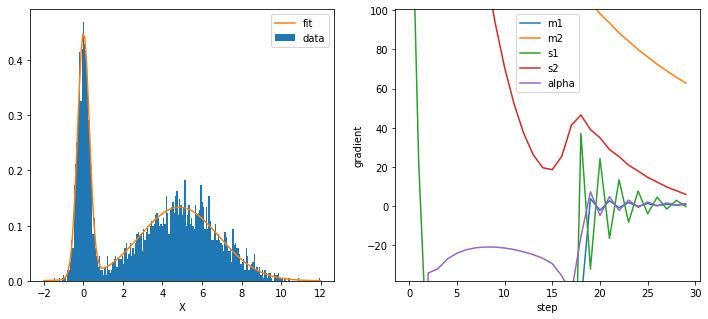

In [8]:
from IPython.display import clear_output


def gaussian(x, mu, sigma):
    """ Defining Gaussian PDF using tf functions with parameters mu and sigma """
    return (1/(np.sqrt(2*np.pi)*sigma))*tf.exp(-1/2*((x - mu)/sigma)**2)


def mixture(x, f1, f2, alpha):
    """ Arbitrary mixture PDF """
    return alpha * f1(x) + (1. - alpha) * f2(x)

# Parameters that we'd like to infer (with an initial guess)
m1    = tf.Variable(1.0, trainable = True)
m2    = tf.Variable(4.0, trainable = True)
s1    = tf.Variable(1.0, trainable = True)
s2    = tf.Variable(1.0, trainable = True)
alpha = tf.Variable(0.5, trainable = True)


def apply_constraints():
    """ Each time the gradient is updated, this function will be applied to
        ensure acceptable parameter values. Ensure the sigmas are positive (greater or equal to some small
        positive number, e.g. 1e-5) and alpha is in (0, 1) interval.
    """
    global m1, m2, s1, s2, alpha
    m1 = m1.assign(m1_learned)
    m2 = m2.assign(m2_learned)
    s1 = s1.assign(s1_learned)
    s2 = s2.assign(s2_learned)
    if (alpha_learned < 1) & (alpha_learned > 0):
        alpha = alpha.assign(alpha_learned)
    else:
        pass

    return m1, m2, s1, s2, alpha

variables = [m1, m2, s1, s2, alpha]

# 
def model_pdf(x):
    """ Defining the overall PDF """
    return mixture(x,
                   lambda t: gaussian(t, m1, s1),
                   lambda t: gaussian(t, m2, s2),
                   alpha)

def loglike(x):
    """ Defining Log likelihood """
    res = tf.reduce_sum(tf.math.log(model_pdf(x)),axis =0)
    return res

learning_rate = 0.0001
grad_history = [] # to keep track of gradient values at different steps

for i in range(30):
    with tf.GradientTape(persistent=True) as t:
    # NOTE: if `variable` was created with `trainable=False`, you need to
    # manually add it to the tape by calling `t.watch(variable)`. By default
    # the variable are created with `trainable=True`
    X = tf.convert_to_tensor(X)
    t.watch(X)
    for j in variables:
        t.watch(j)

    # Forward pass:
    l = loglike(X)
  
  # Backprop:
    grads = [t.gradient(l, m1),
             t.gradient(l, m2),
             t.gradient(l, s1),
             t.gradient(l, s2),
             t.gradient(l, alpha)] # Calculate the gradients
    grad_history.append([g.numpy() for g in grads])
  
  # Gradient ascent step:
    t.watch(variables)

    m1_learned = m1.assign_add(learning_rate*grads[0])
    m2_learned = m2.assign_add(learning_rate*grads[1])
    s1_learned = s1.assign_add(learning_rate*grads[2])
    s2_learned = s2.assign_add(learning_rate*grads[3])
    alpha_learned = alpha.assign_add(learning_rate*grads[4]) # Apply the gradients manually (add

  
    apply_constraints()

  ############################
    # Do some plotting
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(X, bins=200, density=True, label='data')
    x_grid = np.linspace(-2, 12, 150)
    plt.plot(x_grid, model_pdf(x_grid), label='fit')
    plt.legend()
    plt.xlabel('X')

    plt.subplot(1, 2, 2)
    lines = plt.plot(np.array(grad_history))
    low = min(grad_history[-1])
    high = max(grad_history[-1])
    plt.ylim(low  - (high - low) * 0.6,
           high + (high - low) * 0.6)
    plt.legend(lines, ['m1', 'm2', 's1', 's2', 'alpha'])
    plt.xlabel('step')
    plt.ylabel('gradient')
    plt.show()
    clear_output(wait=True);

In [9]:
print('Values of the fitted parameters are: m1 = {}, m2 = {}, s1 = {}, s2 = {}'.format(np.array(m1_learned), np.array(m2_learned), np.array(s1_learned), np.array(s2_learned), np.array(alpha_learned)))
print('Values of the ground truth parameters are: m1 = {}, m2 = {}, s1 = {}, s2 = {}'.format(np.mean(X1), np.mean(X2), np.std(X1), np.std(X2)))

Values of fitted parameters are: m1 = 0.0027658273465931416, m2 = 4.845426559448242, s1 = 0.297227144241333, s2 = 2.0022776126861572
Values of ground truth parameters are: m1 = 0.0040017287246882915, m2 = 4.986109733581543, s1 = 0.3010135889053345, s2 = 1.981326937675476


As we can see fitted scores of variables are correct and close to the ground truth.

# MCMC sampling from fitted Gaussian mixture

It's time to generate sampling algorithm from the fitted distribution.

In [1]:
# Let's define the ground truth parameters of Gaussian Mixture 
m1    = 0.0040
m2    = 4.9861
s1    = 0.3010
s2    = 1.9813
alpha = 0.5

In [2]:
def proposal(x, stepsize):
    """ Defining the proposition with stepsize """
    return np.random.uniform(low=x - 0.5 * stepsize, 
                             high=x + 0.5 * stepsize, 
                             size=x.shape)

def p_acc_MH(x_new, x_old, model_pdf):
    """ Defining the acceptance probability """
    return min(1, (model_pdf(x_new)/model_pdf(x_old)))

def sample_MH(x_old, model_pdf, stepsize):
    """ Return the acceptance decision """
    x_new = proposal(x_old, stepsize)
    
    # here we determine whether the new state is accepted or not:
    # we uniformly select a random number from [0,1] and compare
    # its with the probability of successful acception
    
    accept = np.random.random() < p_acc_MH(x_new, x_old, model_pdf)
    if accept:
        return accept, x_new
    else:
        return accept, x_old
    
def build_MH_chain(init, stepsize, n_total, model_pdf):
    """ Markov chain construction with n_total steps """
    n_accepted = 0
    chain = [init]

    for _ in range(n_total):
        accept, state = sample_MH(chain[-1], model_pdf, stepsize)
        chain.append(state)
        n_accepted += accept
    
    acceptance_rate = n_accepted / float(n_total)
    
    return chain, acceptance_rate

In [7]:
chain, acceptance_rate = build_MH_chain(np.array([2.0]), 3.0, 10000, model_pdf)
chain = [state for state, in chain]
print("Acceptance rate: {:}".format(str(acceptance_rate)))
last_states = ", ".join("{:.5f}".format(state) 
                        for state in chain[-10:])
print("Last ten states of chain: " + last_states)

Acceptance rate: [0.5966]
Last ten states of chain: 4.69184, 4.23387, 4.23387, 5.36202, 6.19418, 6.19418, 7.49286, 6.07107, 6.91247, 6.79977


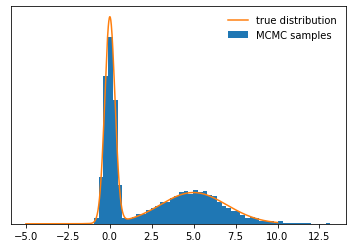

In [8]:
def plot_samples(chain, model_pdf, ax, orientation='vertical', normalize=True,
                 xlims=(-5, 10), legend=True):
    from scipy.integrate import quad
    
    ax.hist(chain, bins=50, density=True, label="MCMC samples",
           orientation=orientation)
    # calculating the normalization constant of the PDF
    # scipy.integrate.quad compute the a definite integral
    if normalize:
        Z, _ = quad(lambda x: model_pdf(x), -np.inf, np.inf)
    else:
        Z = 1.0
    xses = np.linspace(xlims[0], xlims[1], 1000)
    yses = [model_pdf(x) / Z for x in xses]
    if orientation == 'horizontal':
        (yses, xses) = (xses, yses)
    ax.plot(xses, yses, label="true distribution")
    if legend:
        ax.legend(frameon=False)
    
fig, ax = plt.subplots()
plot_samples(chain[500:], model_pdf, ax)
#despine(ax)
ax.set_yticks(())
plt.show()

Acceptance rate: [0.1731]


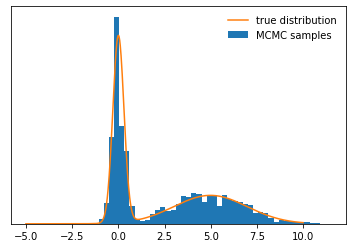

In [9]:
def sample_and_display(init_state, stepsize, n_total, n_burnin, model_pdf):
    chain, acceptance_rate = build_MH_chain(init_state, stepsize, n_total, model_pdf)
    print("Acceptance rate: {:}".format(acceptance_rate))
    fig, ax = plt.subplots()
    plot_samples([state for state, in chain[n_burnin:]], model_pdf, ax)
    #despine(ax)
    ax.set_yticks(())
    plt.show()
    
sample_and_display(np.array([2.0]), 30, 10000, 500, model_pdf)

Acceptance rate: [0.989652]


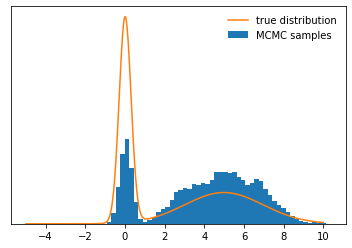

In [10]:
sample_and_display(np.array([2.0]), 0.1, 500000, 500, model_pdf)